In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

# Camera position optimization using differentiable rendering

In this tutorial we will learn the [x, y, z] position of a camera given a reference image using differentiable rendering. 

We will first initialize a renderer with a starting position for the camera. We will then use this to generate an image, compute a loss with the reference image, and finally backpropagate through the entire pipeline to update the position of the camera. 

This tutorial shows how to:
- load a mesh from an `.obj` file
- initialize a `Camera`, `Shader` and `Renderer`,
- render a mesh
- set up an optimization loop with a loss function and optimizer


# 使用可微渲染技术优化调整相机位置等参数

在本教程中，我们将学习使用可微渲染的参考图像给定相机的 [x， y， z] 位置。

我们将首先使用相机的起始位置初始化渲染器。然后，我们将使用它来生成图像，使用参考图像计算损失，最后在整个管道中反向传播以更新相机的位置。

本教程演示如何：
- 从“.obj”文件加载网格
- 初始化“相机”，“着色器”和“渲染器”，
- 渲染网格
- 使用损失函数和优化器设置优化循环

#即假设

已知量原图像为P_r ,
未知量原相机参数为A_r ;
已知关系是图像P 和相机参数A 关系是 ，P = F(A) ; 
通过不断调整 Ai 来得到 Pi, 令pi 和 p_r 不断拟合逼近; 
loss = F(Ai)  - P_r =>0 ; 则 A_r = Ai

##  0. Install and import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [2]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [3]:
import os
import torch
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)

## 1. Load the Obj

We will load an obj file and create a **Meshes** object. **Meshes** is a unique datastructure provided in PyTorch3D for working with **batches of meshes of different sizes**. It has several useful class methods which are used in the rendering pipeline. 
## 1.加载对象

我们将加载一个 obj 文件并创建一个 **网格** 对象。Meshes**是PyTorch3D中提供的独特数据结构，用于处理不同大小的网格批次。它有几个有用的类方法，用于渲染管道。

If you are running this notebook locally after cloning the PyTorch3D repository, the mesh will already be available. **If using Google Colab, fetch the mesh and save it at the path `data/`**:

In [4]:
!mkdir -p data
!wget -P data https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj

��Ŀ¼���ļ� -p �Ѿ����ڡ�
����: -p ʱ������
��Ŀ¼���ļ� data �Ѿ����ڡ�
����: data ʱ������


'wget' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [5]:
# Set the cuda device 
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Load the obj and ignore the textures and materials.
verts, faces_idx, _ = load_obj("./data/teapot.obj")

faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
teapot_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

f:\ai_github_example\cv_git\pytorch3d-main\pytorch3d\pytorch3d\io\obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")




## 2. Optimization setup

### Create a renderer

A **renderer** in PyTorch3D is composed of a **rasterizer** and a **shader** which each have a number of subcomponents such as a **camera** (orthographic/perspective). Here we initialize some of these components and use default values for the rest. 

For optimizing the camera position we will use a renderer which produces a **silhouette** of the object only and does not apply any **lighting** or **shading**. We will also initialize another renderer which applies full **Phong shading** and use this for visualizing the outputs. 

### 创建渲染器

PyTorch3D 中的渲染器由光栅器和着色器组成，每个都有许多子组件，例如相机（正交/透视）。在这里，我们初始化其中一些组件，并对其余组件使用默认值。

为了优化相机位置，我们将使用一个渲染器，它只产生对象的轮廓，不应用任何照明或阴影。我们还将初始化另一个应用完整**Phong阴影**的渲染器，并将其用于可视化输出。

In [6]:
# Initialize a perspective camera.
# 初始化透视相机。
cameras = FoVPerspectiveCameras(device=device)

# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
# 为了混合 100 个面，我们设置了一些参数来控制不透明度和清晰度
# 边缘。有关更多详细信息，请参阅 blending.py。
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
# 定义栅格化和着色的设置。在这里，我们将输出图像设置为大小
# 256x256.为了形成混合图像，我们为每个像素使用来代表 100 张面片。我们还将bin_size和max_faces_per_bin设置为“无”，以确保
# 使用更快的粗到细光栅化方法。请参阅rasterize_meshes.py
# 这些参数的说明。请参阅 docs/notes/renderer.md 了解
# 朴素光栅化和粗到细光栅化之间的区别。
# 光栅化就是把东西画在屏幕上的一个过程 Rasterize == drawing onto the screen 
# 显示设置
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
# 通过组合光栅器和着色器来创建剪影网格渲染器。
# 轮廓渲染（silhouette rendering）
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)


# We will also create a Phong renderer. This is simpler and only needs to render one face per pixel.
# 我们还将创建一个 Phong 渲染器。这更简单，只需要为每个像素渲染一个面。（Phong光照模型）
# 光栅渲染器设置
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)
# We can add a point light in front of the object. 
# 我们可以在对象前面添加一个点光源。
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)

### Create a reference image

We will first position the teapot and generate an image. We use helper functions to rotate the teapot to a desired viewpoint. Then we can use the renderers to produce an image. Here we will use both renderers and visualize the silhouette and full shaded image. 

The world coordinate system is defined as +Y up, +X left and +Z in. The teapot in world coordinates has the spout pointing to the left. 

We defined a camera which is positioned on the positive z axis hence sees the spout to the right. 
### 创建参考镜像

我们将首先定位茶壶并生成图像。我们使用辅助函数将茶壶旋转到所需的视点。然后我们可以使用渲染器来生成图像。在这里，我们将同时使用渲染器并可视化轮廓和全着色图像。

世界坐标系定义为 +Y 向上、+X 向左和 +Z 在。世界坐标中的茶壶的壶嘴指向左侧。

我们定义了一个位于正 z 轴上的相机，因此可以看到右侧的喷口。

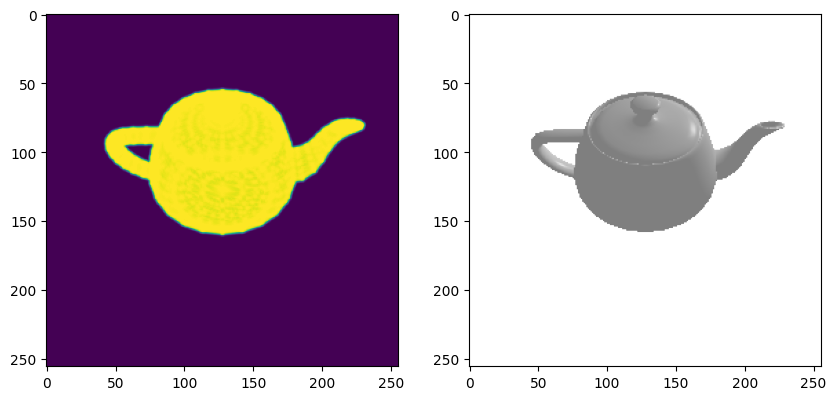

In [7]:
# Select the viewpoint using spherical angles  
# 初始化相机位置，角度，
distance = 3   # distance from camera to the object
elevation = 50.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
# - **R**：相机的当前旋转角度,应用于要与相机对齐的点的旋转。
# - **T**：相机的当前位置，应用于要与相机对齐的点的平移。
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# Render the teapot providing the values of R and T. 
silhouette = silhouette_renderer(meshes_world=teapot_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=teapot_mesh, R=R, T=T)

silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouette.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.grid(False)

### Set up a basic model 

Here we create a simple model class and initialize a parameter for the camera position. 

In [8]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer
        
        # Get the silhouette of the reference RGB image by finding all non-white pixel values. 
        image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(np.float32))
        self.register_buffer('image_ref', image_ref)
        
        # Create an optimizable parameter for the x, y, z position of the camera. 
        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([3.0,  6.9, +2.5], dtype=np.float32)).to(meshes.device))

    def forward(self):
        
        # Render the image using the updated camera position. Based on the new position of the 
        # camera we calculate the rotation and translation matrices
        # 使用更新的相机位置渲染图像。基于新的立场
        # 相机我们计算旋转和平移矩阵
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        
        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T)
        
        # Calculate the silhouette loss
        loss = torch.sum((image[..., 3] - self.image_ref) ** 2) # self.image_ref 临时缓存对象 self.register_buffer('image_ref', image_ref)
        return loss, image
  

## 3. Initialize the model and optimizer

Now we can create an instance of the **model** above and set up an **optimizer** for the camera position parameter. 

In [9]:
# We will save images periodically and compose them into a GIF.
# 我们会定期保存图片并将它们组合成 GIF。
filename_output = "./teapot_optimization_demo.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

# Initialize a model using the renderer, mesh and reference image
model = Model(meshes=teapot_mesh, renderer=silhouette_renderer, image_ref=image_ref).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

### Visualize the starting position and the reference position

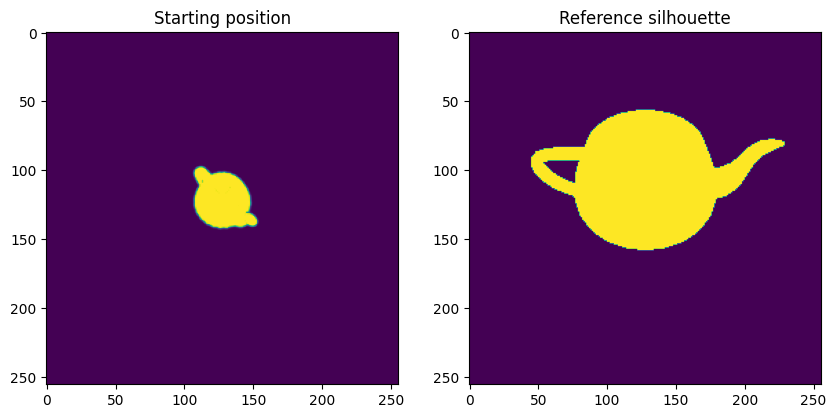

In [10]:
plt.figure(figsize=(10, 10))

_, image_init = model()
plt.subplot(1, 2, 1)
plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(model.image_ref.cpu().numpy().squeeze())
plt.grid(False)
plt.title("Reference silhouette");


## 4. Run the optimization 

We run several iterations of the forward and backward pass and save outputs every 10 iterations. When this has finished take a look at `./teapot_optimization_demo.gif` for a cool gif of the optimization process!

  0%|          | 0/200 [00:00<?, ?it/s]

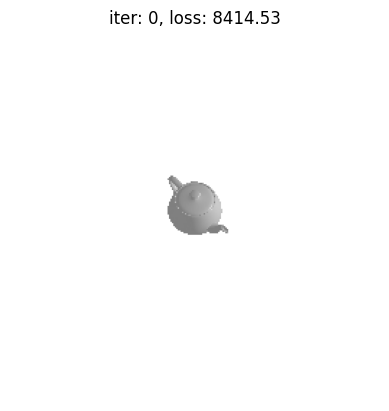

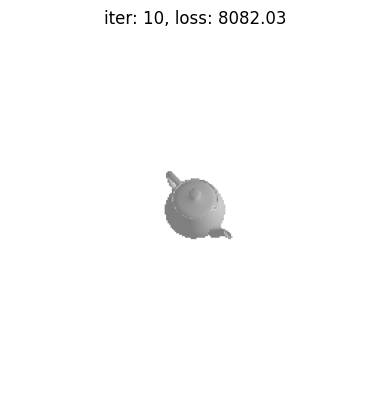

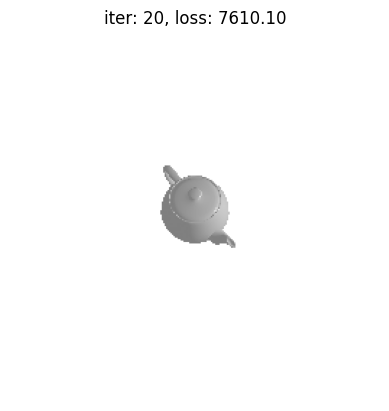

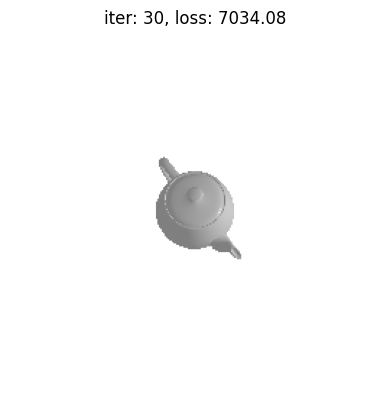

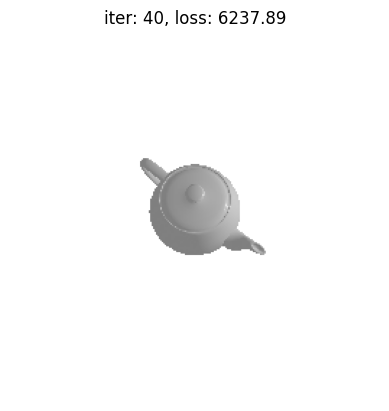

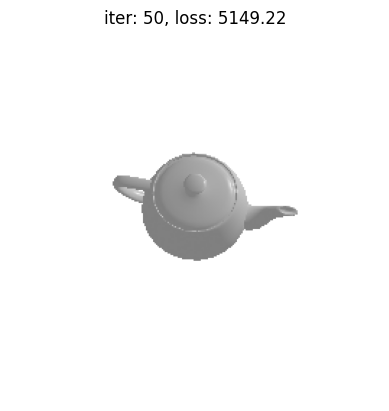

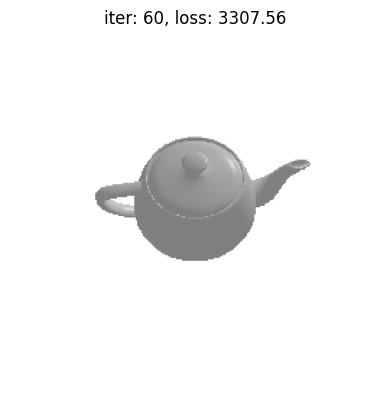

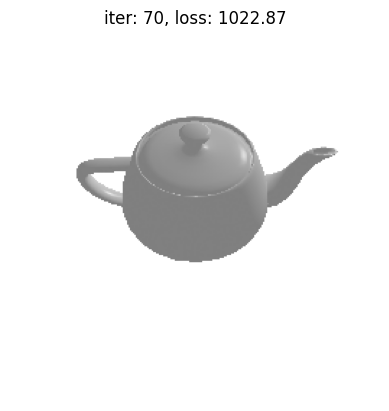

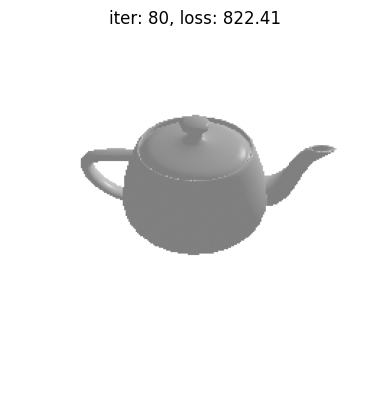

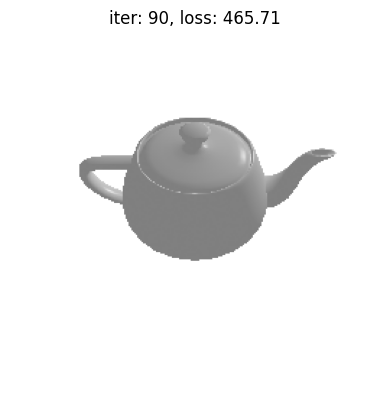

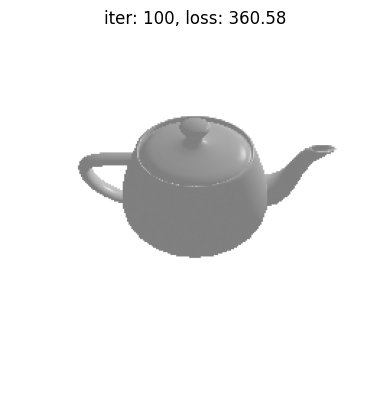

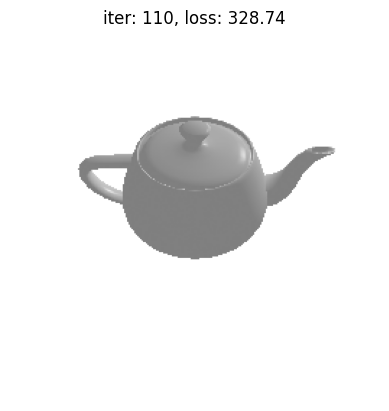

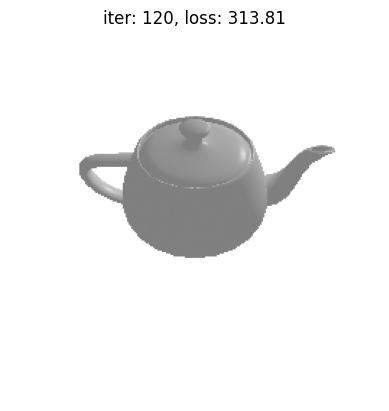

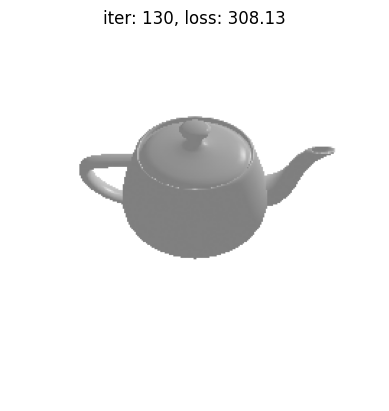

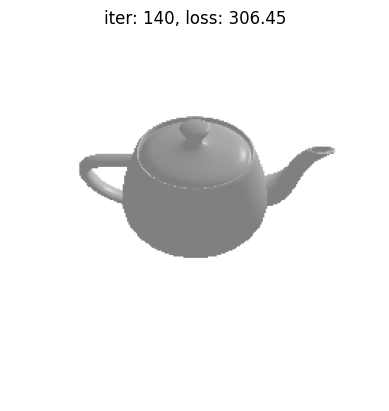

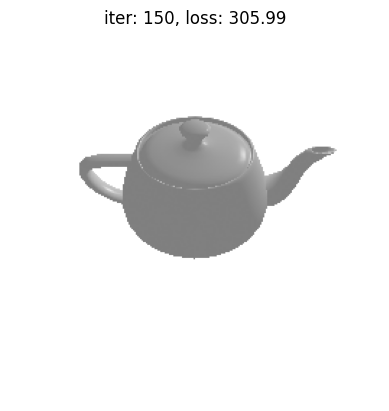

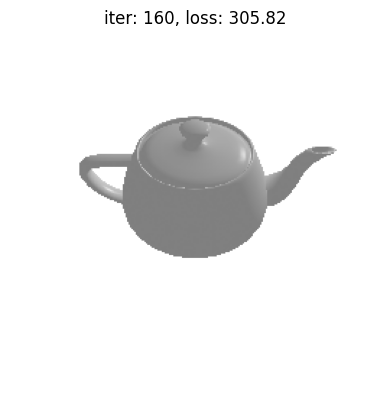

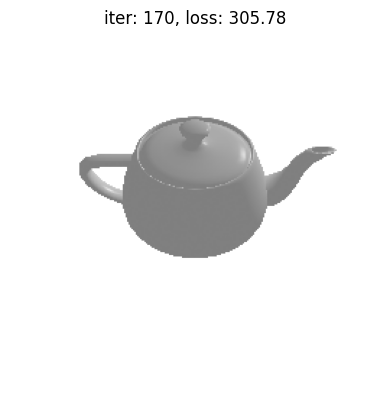

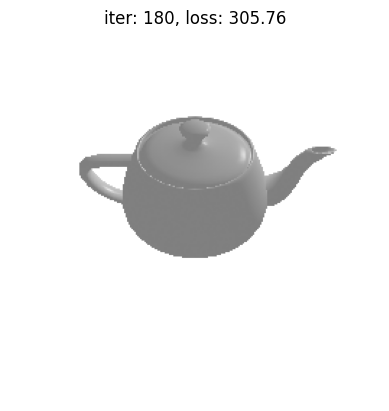

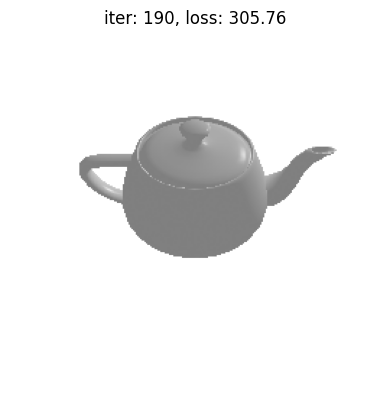

In [11]:
loop = tqdm(range(200))
for i in loop:
    optimizer.zero_grad()
    loss, _ = model()
    loss.backward()
    optimizer.step()
    
    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    
    if loss.item() < 200:
        break
    
    # Save outputs to create a GIF. 
    if i % 10 == 0:
        # look_at_rotation 此函数采用一个向量“camera_position”来指定位置
        # 世界坐标中的相机和两个矢量“at”和“up”，其中
        # 指示物体的位置和世界的向上方向
        # 坐标系分别。假定对象居中于
        # 起源。

        # 输出是表示转换的旋转矩阵
        #     从世界坐标 -> 查看坐标。
        R = look_at_rotation(model.camera_position[None, :], device=model.device)
        T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
        image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        image = img_as_ubyte(image)
        writer.append_data(image)
        
        plt.figure()
        plt.imshow(image[..., :3])
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        plt.axis("off")
    
writer.close()

## 5. Conclusion 

In this tutorial we learnt how to **load** a mesh from an obj file, initialize a PyTorch3D datastructure called **Meshes**, set up an **Renderer** consisting of a **Rasterizer** and a **Shader**, set up an optimization loop including a **Model** and a **loss function**, and run  the optimization. 